## 기존에 처리했던 피마 인디언 데이터 분석에 대한 점수를 고도화 시켜라

* Pregnancies: 임신 횟수
* Glucose: 포도당 부하 검사 수치
* BloodPressure: 혈압(mm Hg)
* SkinThickness: 팔 삼두근 뒤쪽의 피하지방 측정값(mm)
* Insulin: 혈청 인슐린(mu U/ml)
* BMI: 체질량지수(체중(kg)/(키(m))^2)
* DiabetesPedigreeFunction: 당뇨 내력 가중치 값
* Age: 나이
* Outcome: 당뇨병 결과 (0 또는 1)

고도화 목표 : 정확도 : 0.7857, 정밀도 : 0.7333, 재현율 : 0.6111, F1 : 0.6667, AUC : 0.8461 이상

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression # 분류
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [3]:
diabetes_data = pd.read_csv('../ml/data/diabetes.csv')

In [4]:
# Null값은 없음
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


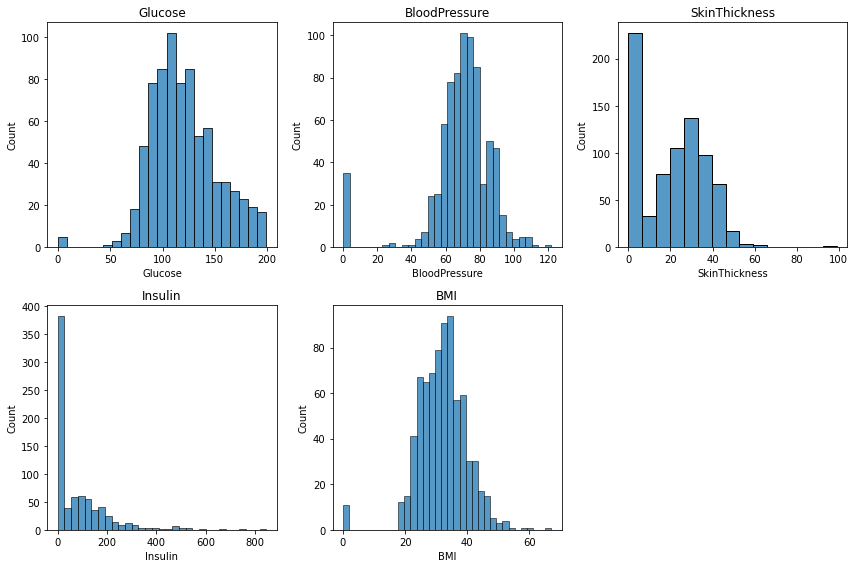

In [6]:
# Glucose(당), BloodPressure(혈압), SkinThickness(팔쪽 피하지방), Insulin(인슐린), BMI(체질량지수)의 min 값이 0일 수 없기 때문에 0인 값의 대체가 필요
# 각 컬럼들의 0의 분포를 확인하기 위해 그래프 생성
zero_col = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

plt.figure(figsize=(12,8))

for idx, x in enumerate(zero_col):
    plt.subplot(2,3, idx+1)
    sns.histplot(data=diabetes_data, x=x)
    plt.title(x)
    
plt.tight_layout()
plt.show()

In [7]:
# 각 컬럼 별로 0이 많은 행들이 있어 최빈값, 평균으로 결측치를 대체 했을 때 그대로 0이 들어갈 확률이 높으므로 4분위 값 중 50%로 대체
# 대체 후 quantile의 50% 값은 변동
diabetes_data[zero_col] = diabetes_data[zero_col].replace(0, diabetes_data[zero_col].quantile(0.5))
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,27.334635,94.652344,32.450911,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,9.229014,105.547598,6.875366,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,23.000000,30.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,31.250000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [8]:
# 오차행렬, 정확도, 정밀도, 재현율 계산 함수 생성
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    
    # ROC-AUC
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    
    # ROC-AUC print 추가
    print(f'정확도 : {accuracy:.4f}, 정밀도 : {precision:.4f}, 재현율 : {recall:.4f}, F1 : {f1:.4f}, AUC : {roc_auc:.4f}')

In [9]:
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, valid_train, valid_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipe = Pipeline([('scaler', StandardScaler()), ('lr_clf', LogisticRegression())])
pipe.fit(X_train, valid_train)
pred_proba = pipe.predict_proba(X_test)[:, 1]
pred = pipe.predict(X_test)
get_clf_eval(valid_test, pred, pred_proba)

오차 행렬
[[82 17]
 [19 36]]
정확도 : 0.7662, 정밀도 : 0.6792, 재현율 : 0.6545, F1 : 0.6667, AUC : 0.8197


In [10]:
param_grid = {'lr_clf__C' : [0.01, 0.05, 0.1, 0.5, 1, 10], 'lr_clf__penalty' : ['l1', 'l2']}

grid_search = GridSearchCV(pipe, cv=10, param_grid=param_grid, scoring='f1')
grid_search.fit(X_train, valid_train)

print(f'Best : {grid_search.best_score_}, using : {grid_search.best_params_}')

Best : 0.6196552026326246, using : {'lr_clf__C': 10, 'lr_clf__penalty': 'l2'}


In [11]:
# score는 낮지만 일단 search한 테스트 진행
pipe.set_params(lr_clf__C=10)
pipe.fit(X_train, valid_train)
pred_proba = pipe.predict_proba(X_test)[:, 1]
pred = pipe.predict(X_test)
get_clf_eval(valid_test, pred, pred_proba)

오차 행렬
[[82 17]
 [19 36]]
정확도 : 0.7662, 정밀도 : 0.6792, 재현율 : 0.6545, F1 : 0.6667, AUC : 0.8189


**다른 모델 테스트**

In [12]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [13]:
# 각각 다른 모델을 파라미터 조절 없이 비교
test_models = {'rf':RandomForestClassifier(), 'xgb':XGBClassifier(), 'lgbm':LGBMClassifier()}

for k, v in test_models.items():
    test_pipe = Pipeline([
            ('std', StandardScaler()),
            ('model', RandomForestClassifier())
        ])
    test_pipe.fit(X_train, valid_train)
    pred = test_pipe.predict(X_test)
    pred_proba = test_pipe.predict_proba(X_test)[:, 1]
    print(f'{k}의 점수는')
    get_clf_eval(valid_test, pred, pred_proba)

rf의 점수는
오차 행렬
[[78 21]
 [18 37]]
정확도 : 0.7468, 정밀도 : 0.6379, 재현율 : 0.6727, F1 : 0.6549, AUC : 0.8288
xgb의 점수는
오차 행렬
[[76 23]
 [19 36]]
정확도 : 0.7273, 정밀도 : 0.6102, 재현율 : 0.6545, F1 : 0.6316, AUC : 0.8215
lgbm의 점수는
오차 행렬
[[76 23]
 [20 35]]
정확도 : 0.7208, 정밀도 : 0.6034, 재현율 : 0.6364, F1 : 0.6195, AUC : 0.8244


In [14]:
# 가장 점수가 높게 나온 LightGBM으로 파이프라인 생성
# verbosity : 0~4단계로 단계에 따라 상태값을 출력해주는 양이 달라짐 0=silent
pipe2 = Pipeline([
    ('std', StandardScaler()),
    ('lgbm', LGBMClassifier())
])

pipe2.fit(X_train, valid_train)
pred = pipe2.predict(X_test)
pred_proba = pipe2.predict_proba(X_test)[:, 1]
get_clf_eval(valid_test, pred, pred_proba)

오차 행렬
[[75 24]
 [17 38]]
정확도 : 0.7338, 정밀도 : 0.6129, 재현율 : 0.6909, F1 : 0.6496, AUC : 0.7710


In [15]:
# num_leaves : (2^max_depth)-1 2의 10승 -1
param_grid = {'lgbm__learning_rate' : [0.01, 0.03, 0.05, 0.1, 0.3, 0.5],
                'lgbm__max_depth':[-1,6,8,10],
                'lgbm__num_leaves':[63,255,1023],
                'lgbm__num_iterations' : [100,300,500]}

grid_search2 = GridSearchCV(pipe2, cv=10, param_grid=param_grid, scoring='f1')
grid_search2.fit(X_train, valid_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('std', StandardScaler()),
                                       ('lgbm', LGBMClassifier())]),
             param_grid={'lgbm__learning_rate': [0.01, 0.03, 0.05, 0.1, 0.3,
                                                 0.5],
                         'lgbm__max_depth': [-1, 6, 8, 10],
                         'lgbm__num_iterations': [100, 300, 500],
                         'lgbm__num_leaves': [63, 255, 1023]},
             scoring='f1')

In [16]:
print(f'Best : {grid_search2.best_score_:.3f}, using : {grid_search2.best_params_}')

Best : 0.664, using : {'lgbm__learning_rate': 0.3, 'lgbm__max_depth': -1, 'lgbm__num_iterations': 100, 'lgbm__num_leaves': 63}


In [17]:
pipe2.set_params(lgbm__learning_rate=0.03, lgbm__max_depth=8, lgbm__num_leaves=63, lgbm__num_iterator=100)
pipe2.fit(X_train, valid_train)
pred_proba = pipe2.predict_proba(X_test)[:, 1]
pred = pipe2.predict(X_test)
get_clf_eval(valid_test, pred, pred_proba)

오차 행렬
[[80 19]
 [17 38]]
정확도 : 0.7662, 정밀도 : 0.6667, 재현율 : 0.6909, F1 : 0.6786, AUC : 0.8200


In [18]:
pipe3 = Pipeline([
    ('std', StandardScaler()),
    ('rf', RandomForestClassifier())
])

pipe3.fit(X_train, valid_train)
pred = pipe3.predict(X_test)
pred_proba = pipe3.predict_proba(X_test)[:, 1]
get_clf_eval(valid_test, pred, pred_proba)

오차 행렬
[[78 21]
 [20 35]]
정확도 : 0.7338, 정밀도 : 0.6250, 재현율 : 0.6364, F1 : 0.6306, AUC : 0.8256


In [19]:
param_grid = {'rf__n_estimators' : [10, 50, 100, 300],
                'rf__max_depth' : [6, 8, 10, 12],
                'rf__min_samples_leaf' : [8, 12, 18],
                'rf__min_samples_split' : [8, 16, 20]
                } # default 10
grid_search3 = GridSearchCV(pipe3, cv=10, param_grid=param_grid, scoring='f1')
grid_search3.fit(X_train, valid_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('std', StandardScaler()),
                                       ('rf', RandomForestClassifier())]),
             param_grid={'rf__max_depth': [6, 8, 10, 12],
                         'rf__min_samples_leaf': [8, 12, 18],
                         'rf__min_samples_split': [8, 16, 20],
                         'rf__n_estimators': [10, 50, 100, 300]},
             scoring='f1')

In [20]:
print(f'Best : {grid_search3.best_score_:.3f}, using : {grid_search3.best_params_}')

Best : 0.643, using : {'rf__max_depth': 8, 'rf__min_samples_leaf': 8, 'rf__min_samples_split': 20, 'rf__n_estimators': 100}


In [21]:
pipe3.set_params(rf__n_estimators=50, rf__max_depth=10, rf__min_samples_leaf=8,\
                    rf__min_samples_split=16)
pipe3.fit(X_train, valid_train)
pred_proba = pipe3.predict_proba(X_test)[:, 1]
pred = pipe3.predict(X_test)
get_clf_eval(valid_test, pred, pred_proba)

오차 행렬
[[80 19]
 [19 36]]
정확도 : 0.7532, 정밀도 : 0.6545, 재현율 : 0.6545, F1 : 0.6545, AUC : 0.8391
